In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from celluloid import Camera
from sklearn.preprocessing import StandardScaler

In [2]:
use_bias = True
standardization = False
samples = 2000
val_split = 0.8

In [67]:
val_split_n = int(samples * val_split)
sig0 = 3 * np.random.randn(samples, 2) - np.arange(2) * 20 
l0 = np.zeros(samples)
sig1 = 7 * np.random.randn(samples, 2) - np.arange(2) * 40 - 40
l1 = np.zeros(samples) + 1

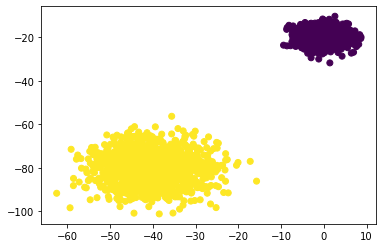

In [68]:
set0 = np.column_stack((sig0,l0))
set1 = np.column_stack((sig1,l1))

dataset = np.concatenate((set0, set1), axis=0)
dataset.astype(np.float32)
np.random.shuffle(dataset)

inp_set = dataset[:, :2]
lab_set = dataset[:, 2].reshape(samples * 2, 1)

if standardization:
	scaler = StandardScaler(copy = False).fit(inp_set)
	inp_set = scaler.transform(inp_set)

input_set = torch.from_numpy(inp_set[:val_split_n])
labels_set = torch.from_numpy(lab_set[:val_split_n])

test_set = torch.from_numpy(inp_set[val_split_n:])
labels_test = torch.from_numpy(lab_set[val_split_n:])

plt.scatter(test_set[:, 0].detach().numpy(), test_set[:, 1].detach().numpy(), c=labels_test.detach().numpy())

In [69]:
class Net(nn.Module):
	def __init__(self):
		super().__init__()
		if use_bias:
			self.fc1 = nn.Linear(2, 1, bias=True)
		else:
			self.fc1 = nn.Linear(2, 1, bias=False)
	def forward(self, x):
		x = torch.tanh(self.fc1(x))
		return x


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=1, bias=True)
)


In [70]:
optimiser = optim.Adam(net.parameters(), lr=0.01)

# fig = plt.figure()
# camera = Camera(fig)

minx = np.min(inp_set[:, :1])
maxx = np.max(inp_set[:, :1])

miny = np.min(inp_set[:, 1:2])
maxy = np.max(inp_set[:, 1:2])

# plt.xlim(minx,maxx)
# plt.ylim(miny, maxy)

xs = np.linspace(minx, maxx, 1000)

EPOCHS = 50
losses = np.zeros(EPOCHS)
acc = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
	net.zero_grad()
	output = net(input_set.float())
	
	loss = F.mse_loss(output, labels_set.float())
	loss.backward()
	optimiser.step()
	losses[epoch] = loss.item()

	out = (output > 0.5).float()
	correct = (out == labels_set).float().sum() / output.shape[0]
	acc[epoch] = correct

	# w = 0
	# b = 0
	# for name, param in net.named_parameters():
	# 	if param.requires_grad:
	# 		if name == 'fc1.weight': w = param.data
	# 		if name == 'fc1.bias': b = param.data

	# k = w[0, 1] / w[0, 0]
	# if use_bias: p = b[0]
	# k1 = - w[0, 0] / w[0, 1]

	# if use_bias: ys1 = k1 * xs + np.mean(test_set[:, 1].detach().numpy())
	# else : ys1 = k1 * xs
	# plt.plot(xs, ys1)

	# plt.scatter(input_set[:, 0].detach().numpy(), input_set[:, 1].detach().numpy(), c=output.detach().numpy())
	# camera.snap()
	

# animation = camera.animate()



In [7]:
# animation.save('celluloid_minimal.mp4', writer='ffmpeg', fps=30)

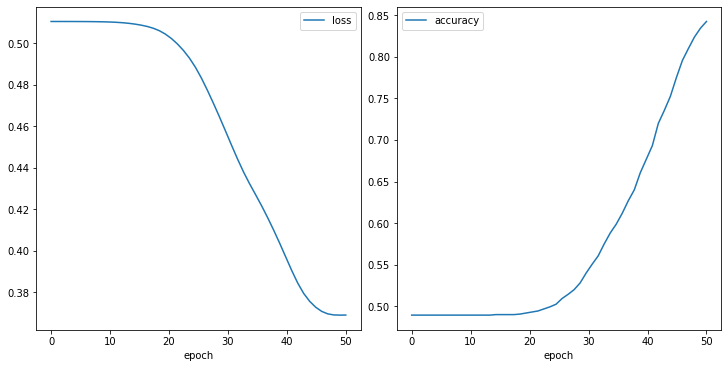

In [71]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10, 5))

axs[0].plot(np.linspace(0, EPOCHS, EPOCHS), losses, label='loss')
axs[0].set_xlabel('epoch')
axs[0].legend()
axs[1].plot(np.linspace(0, EPOCHS, EPOCHS), acc, label='accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend()
plt.show()


fc1.weight tensor([[-0.8811,  0.0215]])
fc1.bias tensor([-0.5529])
acc = 0.8612499833106995


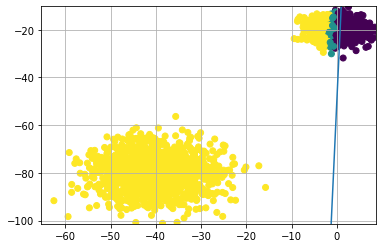

In [75]:
w = 0
b = 0
for name, param in net.named_parameters():
	if param.requires_grad:
		print(name, param.data)
		if name == 'fc1.weight': w = param.data
		if name == 'fc1.bias': b = param.data

k = w[0, 1] / w[0, 0]
if use_bias: p = b[0]
k1 = - w[0, 0] / w[0, 1]



with torch.no_grad():
	pred = net(test_set.float())

	#print(f'f = {k} * x + {p}')
	#print(f'f = {k1} * x')
	#ys = k * xs + p
	if use_bias: ys1 = k1 * xs + np.mean(test_set[:, 1].detach().numpy()) #p / w[0, 1].detach().numpy()
	else : ys1 = k1 * xs

	#plt.plot(xs, ys)
	plt.xlim(minx,maxx)
	plt.ylim(miny, maxy)
	plt.plot(xs, ys1)

	plt.scatter(test_set[:, 0].detach().numpy(), test_set[:, 1].detach().numpy(), c=pred.detach().numpy().round())

	out = (pred > 0.5).float()
	correct = (out == labels_test).float().sum() / pred.shape[0]
	print(f'acc = {correct.detach().numpy()}')


	plt.grid()
	plt.show()
	